# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


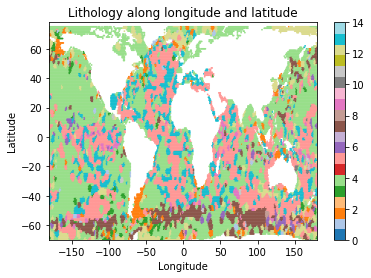

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

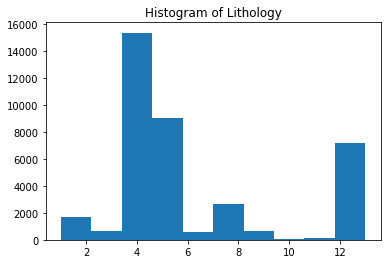

Unique class = [ 1  2  3  4  5  6  7  8  9 10 11 12 13]


In [3]:
# plot the histogram of lithology
plt.hist(y)
plt.title("Histogram of Lithology")
plt.show()
print("Unique class = {}".format(np.unique(y)))

In [4]:
training_data = dfdata.copy()
if "longitude" in training_data or "latitude" in training_data:
    del training_data["longitude"]
    del training_data["latitude"]

# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# construct X and y 
X = training_data[features].as_matrix()
y = training_data[target].as_matrix().astype(int)
print("Features = {}".format(features))

Features = ['bathymetry', 'nitrate', 'oxygen', 'phosphate', 'productivity', 'salinity', 'silicate', 'temperature']


### Neural Network Model

Use Aboleth to train a neural network model on training data

[[ -3.73690203e-02   1.97551990e+00   1.10517728e+00 ...,  -2.39281997e-01
    1.27623427e+00  -1.30192840e+00]
 [ -7.61183262e-01   1.45353937e+00   1.17883813e+00 ...,  -1.28201589e-01
   -5.23501495e-03  -8.40055764e-01]
 [  2.28704154e-01  -6.29445791e-01  -1.02560878e+00 ...,  -1.86087489e-01
   -4.64445919e-01   9.55433190e-01]
 ..., 
 [  2.13288331e+00   5.14500407e-08   1.19316959e+00 ...,  -9.90922451e-01
    0.00000000e+00  -1.55409861e+00]
 [ -3.83799851e-01  -7.48065472e-01  -1.06147170e+00 ...,   9.12223935e-01
   -4.75865781e-01   1.17962933e+00]
 [ -1.16356683e+00  -6.18861556e-01  -9.38951313e-01 ...,   3.59729439e-01
   -4.74567324e-01   1.19317567e+00]]
Tensor("Const_46:0", shape=(13,), dtype=float32)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Iteration 0, loss=297589984.0
Iteration 1000, loss=7082089.5
Iteration 2000, loss=78284.6171875
Iteration 3000, loss=70537.671875
Iteration 4000, loss=75087.9375
Iteration 5000, loss=260901.515625
Iteration 6000, loss

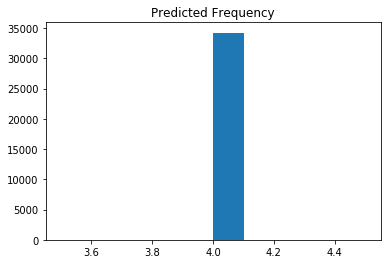

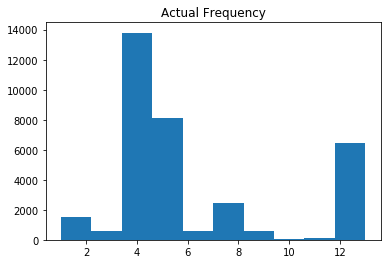

0.402873496087


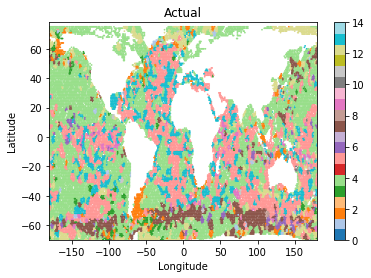

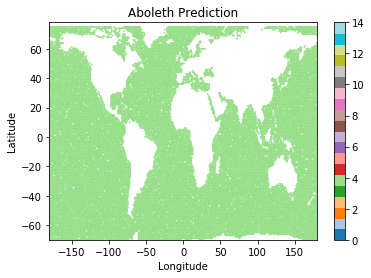

In [55]:
import tensorflow as tf
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import aboleth as ab

FRAC_TEST = 0.1
RSEED = 100
ab.set_hyperseed(RSEED)

# Optimization
NITER = 50000  # Training iterations per fold
BSIZE = 50  # mini-batch size
CONFIG = tf.ConfigProto(device_count={'GPU': 0})  # Use GPU ?
LSAMPLES = 1  # We're only using 1 dropout "sample" for learning to be more
PSAMPLES = 100  # Number of samples for prediction
REG = 0.0001  # weight regularizer
NFEATURES = 8
NCLASSES = 13

rnd = np.random.RandomState(RSEED)
scale = rnd.rand(NFEATURES)
scale = scale[:, None]
lenscale = ab.pos(tf.Variable(scale, dtype=np.float32))

# Network structure
n_samples_ = tf.placeholder_with_default(LSAMPLES, [])
# net = (
#     ab.InputLayer(name="X", n_samples=n_samples_) >>
#     ab.DropOut(0.95) >>
#     ab.DenseMAP(output_dim=512, l1_reg=0., l2_reg=REG) >>
#     ab.Activation(h=tf.nn.relu) >>
#     ab.DropOut(0.95) >>
#     ab.DenseMAP(output_dim=256, l1_reg=0., l2_reg=REG) >>
#     ab.Activation(h=tf.nn.relu) >>
#     ab.DropOut(0.95) >>
#     ab.DenseMAP(output_dim=128, l1_reg=0., l2_reg=REG) >>
#     ab.Activation(h=tf.nn.relu) >>
#     ab.DropOut(0.95) >>
#     ab.DenseMAP(output_dim=64, l1_reg=0., l2_reg=REG) >>
#     ab.Activation(h=tf.nn.relu) >>
#     ab.DenseMAP(output_dim=NCLASSES, l1_reg=0., l2_reg=REG)
# )

net = (
    ab.InputLayer(name='X', n_samples=n_samples_) >>
    ab.RandomArcCosine(n_features=NFEATURES, lenscale=lenscale) >>
    ab.DenseVariational(output_dim=64) >>
    ab.Activation(h=tf.nn.relu) >>
    ab.DenseVariational(output_dim=32) >>
    ab.Activation(h=tf.nn.relu) >>
    ab.DenseVariational(output_dim=16) >>
    ab.Activation(h=tf.nn.relu) >>
    ab.DenseVariational(output_dim=NCLASSES) >>
    ab.Activation(h=tf.nn.relu)
)

X = training_data[features].values.astype(np.float32)
y = training_data[target].values.astype(np.int32)
Y = training_data[target].values.astype(np.int32) - 1
X = StandardScaler().fit_transform(X).astype(np.float32)
N, D = X.shape

# Split the training and testing data
ind_tr, ind_ts = train_test_split(
    range(len(X)),
    test_size=FRAC_TEST,
    random_state=RSEED)

X_tr, X_ts = X[ind_tr], X[ind_ts]
Y_tr, Y_ts = Y[ind_tr], Y[ind_ts]
N_tr, D = X_tr.shape
print(X_tr)
# calculate weights
unique, counts = np.unique(Y_tr, return_counts=True)
weights = np.zeros(13)
for u, c in zip(unique, counts):
    weights[u] = 1.
# calculate weights
tf_weights = tf.constant(weights, dtype=np.float32)
print(tf_weights)
print(weights)

# Benchmark classifier
bcl = RandomForestClassifier(random_state=RSEED)

# Data
with tf.name_scope("Input"):
    X_ = tf.placeholder(dtype=tf.float32, shape=(None, D))
    Y_ = tf.placeholder(dtype=tf.int32, shape=(None,))

# with tf.name_scope("Deepnet"):
#     nn, reg = net(X=X_)
#     lkhood = tf.distributions.Categorical(logits=nn)
#     like_weights = tf.gather(tf_weights, Y_)
#     loss = ab.max_posterior(lkhood, Y_, reg, like_weights=like_weights)
#     prob = ab.sample_mean(lkhood.probs)

with tf.name_scope("Deepnet"):
    nn, kl = net(X=X_)
    lkhood = tf.distributions.Categorical(logits=nn)
    like_weights = tf.gather(tf_weights, Y_)
    loss = ab.elbo(lkhood, Y_, N_tr, kl, like_weights=like_weights)
    prob = ab.sample_mean(lkhood.probs)

with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
    train = optimizer.minimize(loss)

# Launch the graph.
acc, acc_o, ll, ll_o = [], [], [], []
init = tf.global_variables_initializer()

with tf.Session(config=CONFIG):
    init.run()
    batches = ab.batch(
        {X_: X_tr, Y_: Y_tr},
        batch_size=BSIZE,
        n_iter=NITER
    )
    for i, data in enumerate(batches):
        train.run(feed_dict=data)
        if i % 1000 == 0:
            loss_val = loss.eval(feed_dict=data)
            print("Iteration {}, loss={}".format(i, loss_val))
    # prediction
    Ep = prob.eval(feed_dict={X_: X_tr, n_samples_: PSAMPLES})
    
Ey = Ep.argmax(axis=1)
plt.hist(Ey + 1)
plt.title("Predicted Frequency")
plt.show()
plt.hist(Y_tr + 1)
plt.title("Actual Frequency")
plt.show()
print(accuracy_score(Y_tr, Ey))
index = ind_tr
draw_global(lon[index], lat[index], Y_tr + 1, "Actual")
draw_global(lon[index], lat[index], Ey + 1, "Aboleth Prediction")